LHCb RICH system alignment procedure
====

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
from scipy.optimize import curve_fit

Misaligned mirrors $\implies$ shifted Cherenkov rings:

TODO image of a ring with a shifted centre

A simulated Cherenkov ring, with some random (uniformly distributed) background as well:

In [48]:
rng = np.random.default_rng(seed=0)
# Generate points uniformly in phi, gaussian in r; then transform to x, y
# This is what the fit looks for; it's just easier to plot in x and y
n_sig = 20000
r0 = 0.5
width = 0.05

offset = (-0.08, 0.45)

r = r0 + rng.normal(scale=width, size=n_sig)
phi = 2 * np.pi * rng.random(n_sig)

x = r * np.cos(phi)
y = r * np.sin(phi)

x += offset[0]
y += offset[1]

r = np.sqrt(x ** 2 + y ** 2)
phi_sig = np.arctan2(y, x)

# Background is uniform in a circle
n_bkg = 2000
background = 2 * rng.random(size=(2, n_bkg)) - 1

max_r = 1
r_bkg = max_r * np.sqrt(rng.random(size=n_bkg))
phi_bkg = 2 * np.pi * rng.random(size=n_bkg) - np.pi

<IPython.core.display.Javascript object>


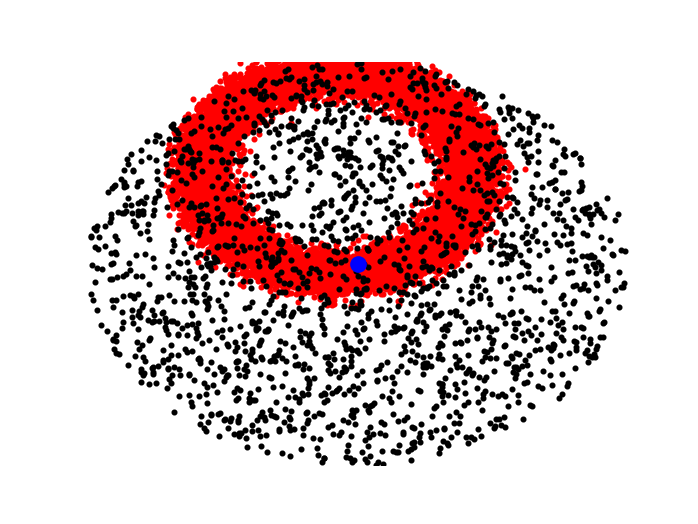

In [49]:
fig, ax = plt.subplots()

ax.plot(x, y, "r.")
ax.plot(r_bkg * np.cos(phi_bkg), r_bkg * np.sin(phi_bkg), "k.")
ax.plot([0], [0], "b.", markersize=20)

ax.set_xlim(-max_r, max_r)
ax.set_ylim(-max_r, max_r)
ax.axis("off")
None

For our fits, its easier to work in a $\delta \theta - \phi$ co-ordinate system.

$\delta \theta$ is defined as $\delta \theta(\phi) = \theta(\phi) - \theta_C$, where $\theta_C$ is our expected Cherenkov angle.

We select only "saturated tracks" - tracks with high enough momentum that the expected Cherenkov angle is independent of the particle mass and momentum:

$ \mathrm{cos}\theta_C = 1 / n$

Where n is the refractive index of the RICH 1 or 2 medium (or possibly the other stuff at the entrance to one of them TODO remember what that is).

If the distance between the secondary mirror and the photodetector is $d$, we find that the Cherenkov angle is given by:

$\mathrm{tan}\theta = \frac{r}{d}$ 

In [50]:
delta_theta_bkg = np.arctan(r_bkg) - np.arctan(r0)
delta_theta_sig = np.arctan(r) - np.arctan(r0)

<IPython.core.display.Javascript object>


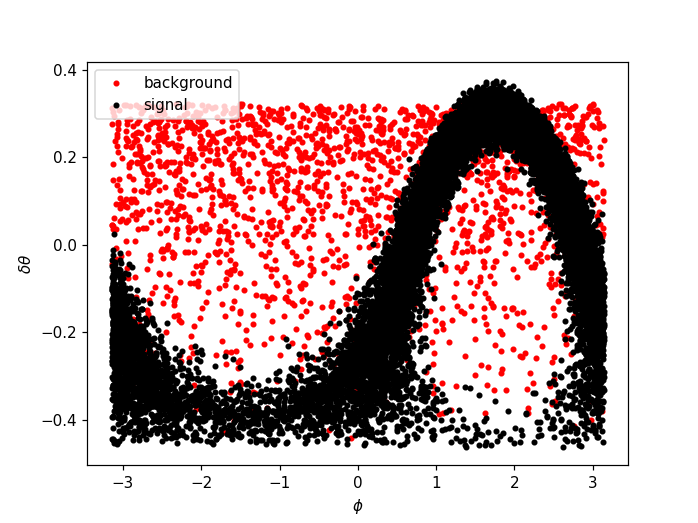

In [51]:
fig, ax = plt.subplots()

ax.plot(phi_bkg, delta_theta_bkg, "r.", label="background")
ax.plot(phi_sig, delta_theta_sig, "k.", label="signal")

ax.legend()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\delta \theta$")
None

Clearly, most of the signal occurrs at small delta-theta (as might be expected - most of the hits are near where we expect them to be)

It's also easier to fit to a histogram instead of a scatter plot:


In [41]:
phi = np.concatenate((phi_bkg, phi_sig))
delta_theta = np.concatenate((delta_theta_bkg, delta_theta_sig))

<IPython.core.display.Javascript object>


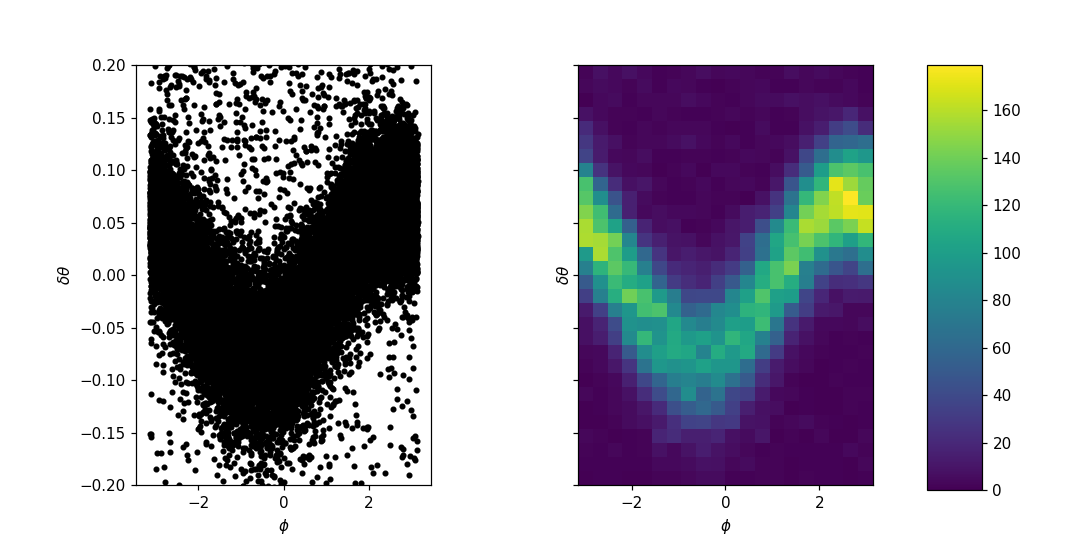

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

bins = (np.linspace(-np.pi, np.pi, 21), np.linspace(-0.2, 0.2, 31))
ax[0].plot(phi, delta_theta, "k.")
hist, _, _, hist_img = ax[1].hist2d(phi, delta_theta, bins=bins)

for a in ax:
    a.set_xlabel(r"$\phi$")
    a.set_ylabel(r"$\delta \theta$")

fig.subplots_adjust(right=0.8, wspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.78])
fig.colorbar(hist_img, cax=cbar_ax)
None

We now fit to Gaussian each column in the histogram.

Our signal component is a Gaussian; the background is a second order polynomial.

We can choose to do these fits with either the same or a separate width for each histogram; we would intuitively expect the width of each Gaussian to be the same (it corresponds to the thickness of the RICH ring). In the real fit, it was also found that this makes the fit much faster.

<IPython.core.display.Javascript object>


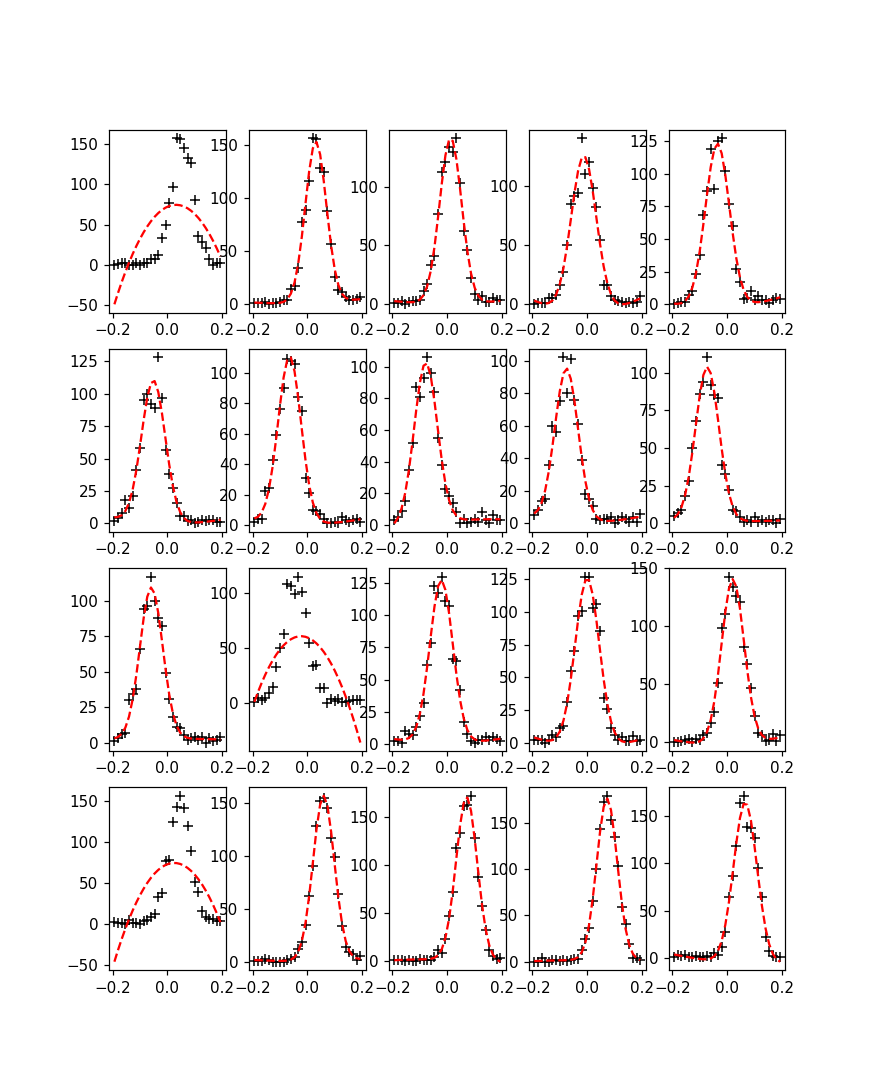

/home/mh19137/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/mh19137/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/mh19137/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [43]:
def fit_fcn(x, width, mean, a, b, c, n):
    return a + b * x + c * x * x + n * norm.pdf(x, mean, width)


theta_centres = (bins[1][1:] + bins[1][:-1]) / 2
fig, ax = plt.subplots(4, 5, figsize=(8, 10))

means = []

for column, axis in zip(hist, ax.ravel()):
    popt, _ = curve_fit(fit_fcn, theta_centres, column, p0=(width, 0, 0, 0, 0, 1))
    axis.plot(theta_centres, column, "k+")
    axis.plot(theta_centres, fit_fcn(theta_centres, *popt), "r--")
    means.append(popt[1])

Connecting the means of these together gives us a sinusoidal curve on our $\delta \theta - \phi$ histogram:

<IPython.core.display.Javascript object>


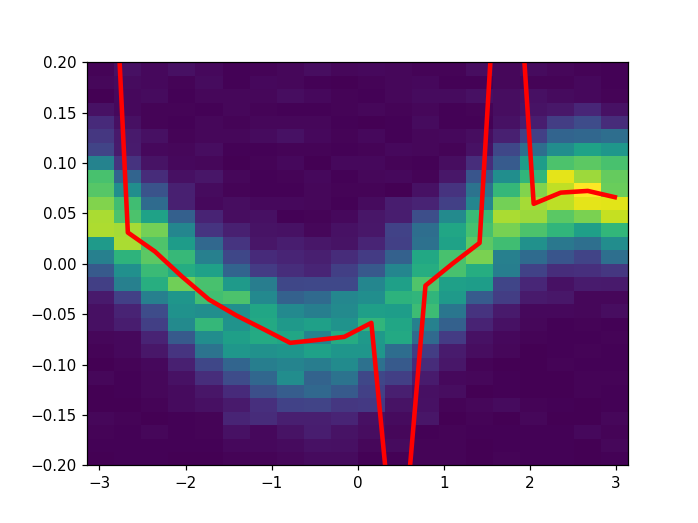

In [44]:
fig, ax = plt.subplots()

phi_centres = (bins[0][1:] + bins[0][:-1]) / 2
hist, _, _, _ = ax.hist2d(phi, delta_theta, bins=bins)
ax.plot(phi_centres, means, "r-", linewidth=3)
None

In reality, we constrain the means to fit on a sinusoid, finding the best parameters.

We also enforce that the width of each Gaussian is the same.

In reality we also fit a second-order polynomial background component - this is omitted here because it's easier.

In [45]:
from typing import Tuple
from iminuit import Minuit
from iminuit.util import make_func_code
from iminuit.cost import BinnedNLL
from time import sleep


class CombinedChi2:
    """
    Combined chi2 for the simultaneous fit to all bins

    Doesn't fit to the background for now

    """

    errordef = Minuit.LEAST_SQUARES

    def __init__(self, hist: np.ndarray, bins: Tuple[np.ndarray, np.ndarray]):
        """
        Initialise the fitter
        Assumes constant width theta bins

        :param hist: 2d histogram of photodetector hits
        :param bins: the phi and theta bins, respectively

        """
        self.hist = hist

        self.phi_bins, self.theta_bins = bins

        # Bin centres
        self.phi_centres = (self.phi_bins[1:] + self.phi_bins[:-1]) / 2
        self.theta_centres = (self.theta_bins[1:] + self.theta_bins[:-1]) / 2
        self.theta_width = self.theta_centres[1] - self.theta_centres[0]

        # We need to tell Minuit what our function signature is
        # In this case we're fitting to 2 components of the sinusoid (Asinx + Bcosx) and the width of the Gaussian
        self.func_code = make_func_code(["A", "B", "width"])
        
        # All the parameters that we tried
        self.params = []

    def sinusoid(self, x: np.ndarray, A: float, B: float) -> np.ndarray:
        """
        The sinusoid describing the relationship between the peaks at each phi value

        """
        return A * np.sin(self.phi_centres) + B * np.cos(self.phi_centres)
    
    def values(self, A: float, B: float) -> Tuple[np.ndarray, np.ndarray]:
        """
        The x and y arrays to be plotted
        
        """
        return self.phi_centres, self.sinusoid(self.phi_centres, A, B)
    
    def errorbar(self, ax: plt.Axes, A: float, B: float, width: float) -> None:
        """
        Plot errorbar on an axis
        
        """
        ax.errorbar(self.phi_centres, self.sinusoid(self.phi_centres, A, B), yerr=width, fmt="k+")

    def _gaussian(self, x: np.ndarray, width: float, mean: float) -> np.ndarray:
        """
        The gaussian signal peak, normalised

        """
        return norm.pdf(x, mean, width)

    def __call__(self, A: float, B: float, width: float):
        """
        Evaluate chi2 given our parameters

        """
        # Store these params
        self.params.append((A, B, width))
        
        # Find the means from the sinusoid
        means = self.sinusoid(self.phi_centres, A, B)

        # Find the gaussian values for each column
        vals = [
            np.sum(col) * self.theta_width * norm.pdf(self.theta_centres, mean, width)
            for col, mean in zip(self.hist, means)
        ]

        # Find the chi2 of each column
        # Add a small number to the error to make sure we dont divide by 0
        epsilon = 0.0001
        chi2s = [
            np.sum((column - val) ** 2 / (column + epsilon))
            for column, val in zip(self.hist, vals)
        ]
        return np.sum(chi2s)

In [46]:
# Initialise a minimser
chi2 = CombinedChi2(hist, bins)
minimiser = Minuit(chi2, A=0, B=0, width=width)
# minimiser.limits = (-0.2, 0.2), (-0.2, 0.2), (0, None)

# Do the fit
minimiser.migrad()
None

<IPython.core.display.Javascript object>


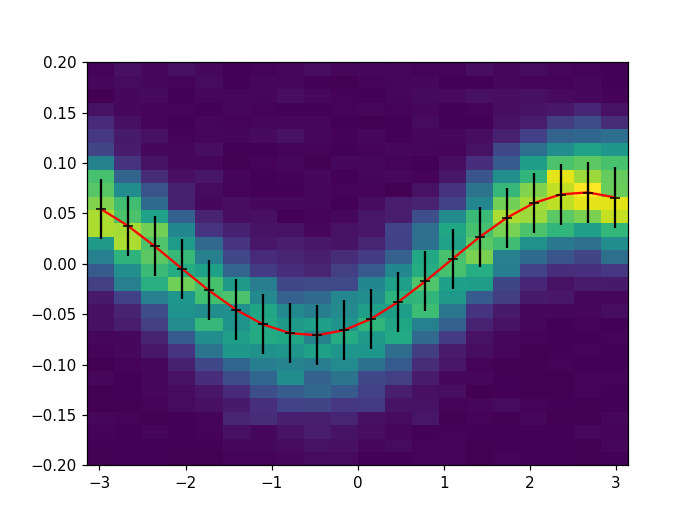

In [47]:
# Also initialise a figure + plot the histogram on it... we can use this to plot the fit as it happens
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()    
hist, _, _, _ = ax.hist2d(phi, delta_theta, bins=bins)
chi2.errorbar(ax, *minimiser.values)

# Animation
line, = ax.plot([], [], "r-")
def update(params):
    x, y = chi2.values(*params[:-1])
    line.set_data(x, y)
    return line,

ani = FuncAnimation(fig, update, frames=chi2.params)
ani.save("animation.mp4", fps=10)
None